In [1]:
import yfinance as yf
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns  # Importing seaborn for data visualization


In [1]:
import yfinance as yf
import pandas as pd

# Fetch historical S&P 500 data in daily timeframe
sp500_data = yf.download('^GSPC', start='2017-01-01', end='2023-01-01')

# Resample the data to end of year and calculate the annual return
sp500_data['Annual Return'] = sp500_data['Close'].resample('Y').ffill().pct_change()

# Extract the annual returns for the past 5 years
annual_returns = sp500_data['Annual Return'].dropna()[-5:]

# Display the annual returns
print("S&P 500 Annual Returns for the Past 5 Years:")
print(annual_returns)


[*********************100%%**********************]  1 of 1 completed

S&P 500 Annual Returns for the Past 5 Years:
Date
2018-12-31   -0.062373
2019-12-31    0.288781
2020-12-31    0.162589
2021-12-31    0.268927
Name: Annual Return, dtype: float64


# LINEAR REGRESSION

[*********************100%%**********************]  1 of 1 completed


Daily Mean Squared Error: 3.650596123580153e-08
Daily R^2 Score: 0.9997418450889732


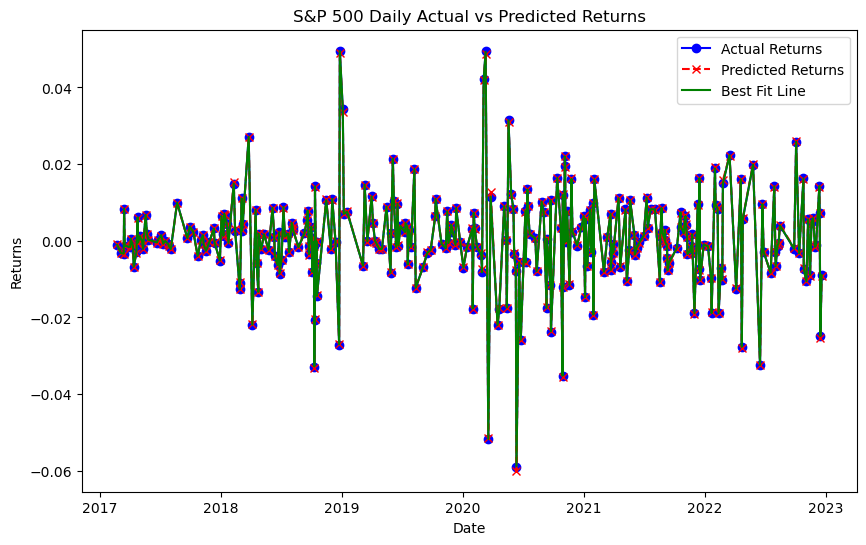

Correlation Matrix:
                  Open      High       Low       RSI  GoldenCross  \
Open          1.000000  0.999613  0.999388 -0.067562     0.167230   
High          0.999613  1.000000  0.999151 -0.074084     0.163798   
Low           0.999388  0.999151  1.000000 -0.051761     0.170432   
RSI          -0.067562 -0.074084 -0.051761  1.000000     0.047960   
GoldenCross   0.167230  0.163798  0.170432  0.047960     1.000000   
Lagged_Close  0.999654  0.999125  0.998764 -0.071008     0.167080   
PriceChange  -0.020064 -0.003274  0.004118  0.210056    -0.004217   
LogReturns   -0.022174 -0.006286  0.000863  0.205203    -0.011993   
PriceRatio    0.019505  0.017074  0.037348  0.570141    -0.036874   
MACD          0.104482  0.092585  0.118046  0.620151     0.141140   
UpperBand     0.981784  0.984050  0.978114 -0.182855     0.138198   
LowerBand     0.990826  0.990440  0.990140 -0.129927     0.194940   
ATR           0.378398  0.390272  0.363624 -0.382637    -0.148358   
VolumeChange  

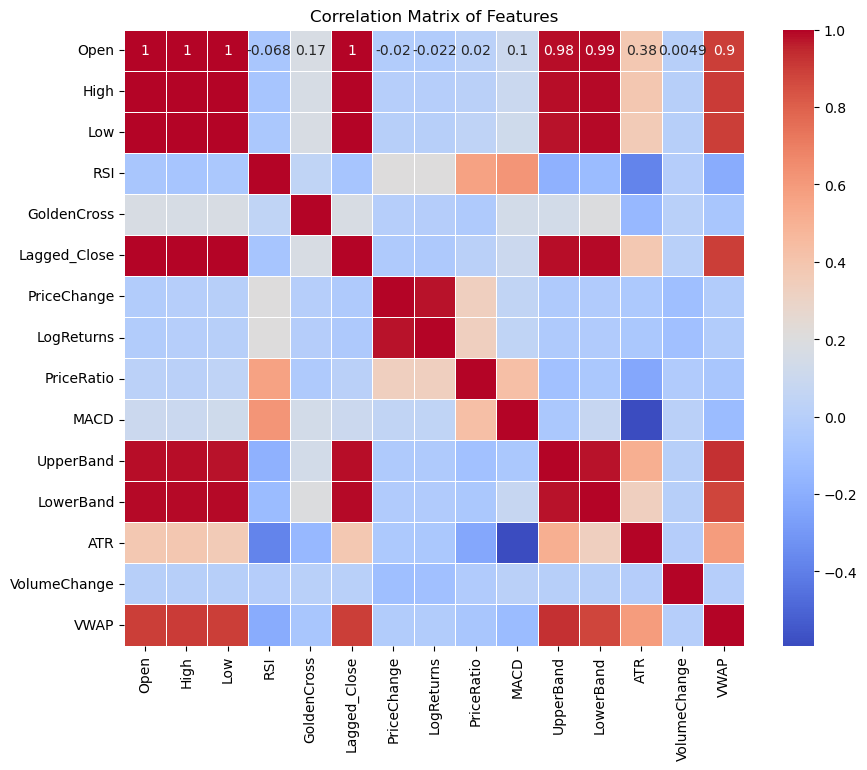

In [43]:
import yfinance as yf
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Fetch historical S&P 500 data in daily timeframe
sp500_data = yf.download('^GSPC', start='2017-01-01', end='2023-01-01')

# Calculate RSI
delta = sp500_data['Close'].diff(1)
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss
sp500_data['RSI'] = 100 - (100 / (1 + rs))

# Calculate Moving Averages for Golden Cross
sp500_data['MA50'] = sp500_data['Close'].rolling(window=50).mean()
sp500_data['MA200'] = sp500_data['Close'].rolling(window=200).mean()

# Create Golden Cross indicator (1 if MA50 > MA200, else 0)
sp500_data['GoldenCross'] = np.where(sp500_data['MA50'] > sp500_data['MA200'], 1, 0)

# Calculate additional features
sp500_data['PriceChange'] = sp500_data['Close'].diff(1)
sp500_data['LogReturns'] = np.log(sp500_data['Close'] / sp500_data['Close'].shift(1))
sp500_data['PriceRatio'] = sp500_data['Close'] / sp500_data['Close'].shift(7)  # 7-day ratio
sp500_data['EMA12'] = sp500_data['Close'].ewm(span=12, adjust=False).mean()
sp500_data['EMA26'] = sp500_data['Close'].ewm(span=26, adjust=False).mean()
sp500_data['MACD'] = sp500_data['EMA12'] - sp500_data['EMA26']
sp500_data['20SMA'] = sp500_data['Close'].rolling(window=20).mean()
sp500_data['StdDev'] = sp500_data['Close'].rolling(window=20).std()
sp500_data['UpperBand'] = sp500_data['20SMA'] + (sp500_data['StdDev'] * 2)
sp500_data['LowerBand'] = sp500_data['20SMA'] - (sp500_data['StdDev'] * 2)
sp500_data['ATR'] = sp500_data['High'].rolling(window=14).max() - sp500_data['Low'].rolling(window=14).min()
sp500_data['VolumeChange'] = sp500_data['Volume'].diff(1)
sp500_data['VWAP'] = (sp500_data['Volume'] * sp500_data['Close']).cumsum() / sp500_data['Volume'].cumsum()

# Calculate the lagged closing price (previous day's closing price)
sp500_data['Lagged_Close'] = sp500_data['Close'].shift(1)

# Calculate daily returns (percentage change in closing prices)
sp500_data['Return'] = sp500_data['Close'].pct_change()

# Prepare the data with all specified features and returns as the target variable
features = ['Open', 'High', 'Low', 'RSI', 'GoldenCross', 'Lagged_Close', 'PriceChange', 'LogReturns',
            'PriceRatio', 'MACD', 'UpperBand', 'LowerBand', 'ATR', 'VolumeChange', 'VWAP']

# Drop rows with NaN values in both features and target
data = sp500_data[features + ['Return']].dropna()

# Split the features and target
X_daily = data[features]
y_daily = data['Return']

# Split the data into training and testing sets
X_train_daily, X_test_daily, y_train_daily, y_test_daily = train_test_split(X_daily, y_daily, test_size=0.2, random_state=42)

# Train the Linear Regression model on daily data
model_daily = LinearRegression()
model_daily.fit(X_train_daily, y_train_daily)

# Predict returns on the test set
y_pred_lr = model_daily.predict(X_test_daily)

# Evaluate the model
mse_daily = mean_squared_error(y_test_daily, y_pred_lr)
r2_daily = r2_score(y_test_daily, y_pred_lr)

print(f"Daily Mean Squared Error: {mse_daily}")
print(f"Daily R^2 Score: {r2_daily}")

# Sort data for plotting
y_test_daily_sorted = y_test_daily.sort_index()
y_pred_daily_sorted = pd.Series(y_pred_lr, index=y_test_daily.index).sort_index()

# Plot the actual and predicted returns
plt.figure(figsize=(10, 6))
plt.plot(y_test_daily_sorted.index, y_test_daily_sorted, label='Actual Returns', color='blue', marker='o')
plt.plot(y_pred_daily_sorted.index, y_pred_daily_sorted, label='Predicted Returns', color='red', linestyle='--', marker='x')

# Add a line of best fit for predicted returns
z_daily = np.polyfit(y_test_daily_sorted, y_pred_daily_sorted, 1)
p_daily = np.poly1d(z_daily)
plt.plot(y_test_daily_sorted.index, p_daily(y_test_daily_sorted), label='Best Fit Line', color='green', linestyle='-')

plt.title('S&P 500 Daily Actual vs Predicted Returns')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.legend()
plt.show()

# Create a correlation matrix
corr_matrix = X_daily.corr()

# Display the correlation matrix
print("Correlation Matrix:")
print(corr_matrix)

# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix of Features')
plt.show()


# RANDOM FOREST

In [45]:
import yfinance as yf
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, classification_report

# Fetch historical S&P 500 data in daily timeframe
sp500_data = yf.download('^GSPC', start='2017-01-01', end='2023-01-01')

# Calculate RSI
delta = sp500_data['Close'].diff(1)
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss
sp500_data['RSI'] = 100 - (100 / (1 + rs))

# Calculate Moving Averages for Golden Cross
sp500_data['MA50'] = sp500_data['Close'].rolling(window=50).mean()
sp500_data['MA200'] = sp500_data['Close'].rolling(window=200).mean()

# Create Golden Cross indicator (1 if MA50 > MA200, else 0)
sp500_data['GoldenCross'] = np.where(sp500_data['MA50'] > sp500_data['MA200'], 1, 0)

# Calculate additional features
sp500_data['PriceChange'] = sp500_data['Close'].diff(1)
sp500_data['LogReturns'] = np.log(sp500_data['Close'] / sp500_data['Close'].shift(1))
sp500_data['PriceRatio'] = sp500_data['Close'] / sp500_data['Close'].shift(7)  # 7-day ratio
sp500_data['EMA12'] = sp500_data['Close'].ewm(span=12, adjust=False).mean()
sp500_data['EMA26'] = sp500_data['Close'].ewm(span=26, adjust=False).mean()
sp500_data['MACD'] = sp500_data['EMA12'] - sp500_data['EMA26']
sp500_data['20SMA'] = sp500_data['Close'].rolling(window=20).mean()
sp500_data['StdDev'] = sp500_data['Close'].rolling(window=20).std()
sp500_data['UpperBand'] = sp500_data['20SMA'] + (sp500_data['StdDev'] * 2)
sp500_data['LowerBand'] = sp500_data['20SMA'] - (sp500_data['StdDev'] * 2)
sp500_data['ATR'] = sp500_data['High'].rolling(window=14).max() - sp500_data['Low'].rolling(window=14).min()
sp500_data['VolumeChange'] = sp500_data['Volume'].diff(1)
sp500_data['VWAP'] = (sp500_data['Volume'] * sp500_data['Close']).cumsum() / sp500_data['Volume'].cumsum()

# Calculate the lagged closing price (previous day's closing price)
sp500_data['Lagged_Close'] = sp500_data['Close'].shift(1)

# Calculate daily returns (percentage change in closing prices)
sp500_data['Return'] = sp500_data['Close'].pct_change()

# Prepare the data with all specified features and returns as the target variable
features = ['Open', 'High', 'Low', 'RSI', 'GoldenCross', 'Lagged_Close', 'PriceChange', 'LogReturns',
            'PriceRatio', 'MACD', 'UpperBand', 'LowerBand', 'ATR', 'VolumeChange', 'VWAP']

# Drop rows with NaN values in both features and target
data = sp500_data[features + ['Return']].dropna()

# Split the features and target
X_daily = data[features]
y_daily = data['Return']

# Split the data into training and testing sets
X_train_daily, X_test_daily, y_train_daily, y_test_daily = train_test_split(X_daily, y_daily, test_size=0.2, random_state=42)

# Initialize and train the Random Forest Regressor
rf_model_reg = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model_reg.fit(X_train_daily, y_train_daily)

# Predict returns on the test set
y_pred_rf_reg = rf_model_reg.predict(X_test_daily)

# Evaluate the regressor model
mse_rf = mean_squared_error(y_test_daily, y_pred_rf_reg)
r2_rf = r2_score(y_test_daily, y_pred_rf_reg)

print(f"Random Forest Regressor Mean Squared Error: {mse_rf}")
print(f"Random Forest Regressor R^2 Score: {r2_rf}")

# Convert the returns to binary classes for classification (1 if return > 0, else 0)
y_daily_class = (y_daily > 0).astype(int)

# Split the data into training and testing sets for classification
X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(X_daily, y_daily_class, test_size=0.2, random_state=42)

# Initialize and train the Random Forest Classifier
rf_model_class = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model_class.fit(X_train_class, y_train_class)

# Predict classes on the test set
y_pred_rf_class = rf_model_class.predict(X_test_class)

# Evaluate the classifier model
accuracy_rf = accuracy_score(y_test_class, y_pred_rf_class)
print(f"Random Forest Classifier Accuracy: {accuracy_rf}")

# Print classification report
print("Classification Report:")
print(classification_report(y_test_class, y_pred_rf_class))


[*********************100%%**********************]  1 of 1 completed


Random Forest Regressor Mean Squared Error: 1.032267698778787e-06
Random Forest Regressor R^2 Score: 0.9927002339641816
Random Forest Classifier Accuracy: 1.0
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       147
           1       1.00      1.00      1.00       152

    accuracy                           1.00       299
   macro avg       1.00      1.00      1.00       299
weighted avg       1.00      1.00      1.00       299



## RANDOM FOREST WITH PCA

[*********************100%%**********************]  1 of 1 completed


Explained Variance Ratio by each Principal Component:
[0.4696577  0.18119075 0.12360954 0.07084792 0.06495763 0.04152937]

PCA Component Loadings:
         Open      High       Low       RSI  GoldenCross  Lagged_Close  \
PC1  0.372714  0.373272  0.371465 -0.063075     0.052794      0.372884   
PC2 -0.070603 -0.070289 -0.086763 -0.455495    -0.094060     -0.063609   
PC3 -0.051386 -0.035554 -0.045376 -0.211046    -0.203330     -0.060468   
PC4  0.003914  0.005685  0.007914 -0.223962     0.831693      0.000918   
PC5  0.003117 -0.000890  0.004095  0.042844    -0.105936      0.006623   
PC6 -0.033979 -0.032921 -0.039168  0.297827     0.457332     -0.029781   

     PriceChange  LogReturns  PriceRatio      MACD  UpperBand  LowerBand  \
PC1    -0.016382   -0.017450   -0.023504 -0.005650   0.375529   0.369711   
PC2    -0.378791   -0.377251   -0.448088 -0.429327   0.015017  -0.047883   
PC3     0.542319    0.542499   -0.016643 -0.411804   0.022252  -0.054034   
PC4     0.153110    0.148464  

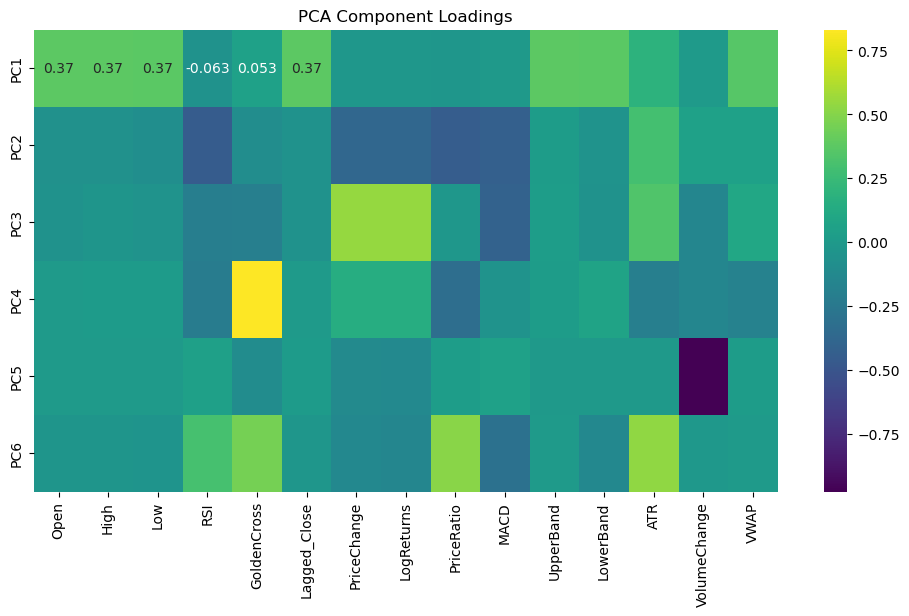

Random Forest Regressor Mean Squared Error: 6.044886062051204e-06
Random Forest Regressor R^2 Score: 0.9572530904354011
Random Forest Classifier Accuracy: 0.9096989966555183
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.88      0.91       147
           1       0.89      0.94      0.91       152

    accuracy                           0.91       299
   macro avg       0.91      0.91      0.91       299
weighted avg       0.91      0.91      0.91       299



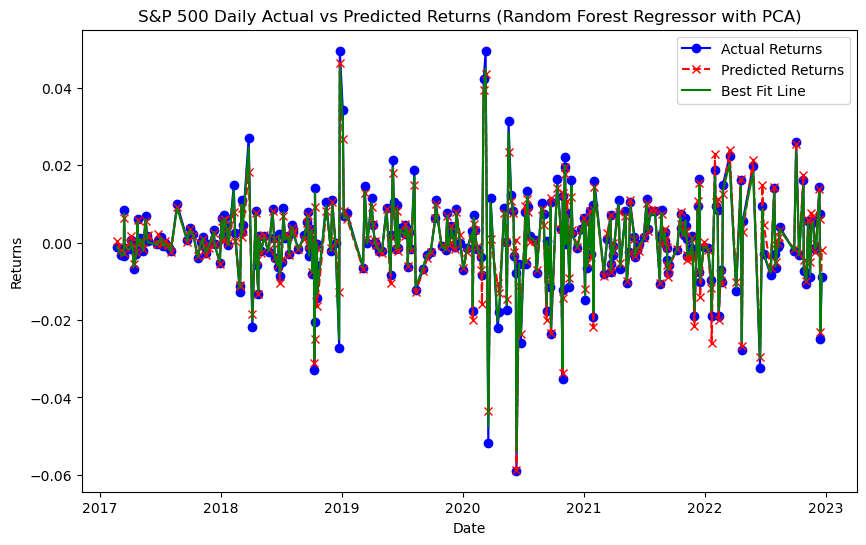

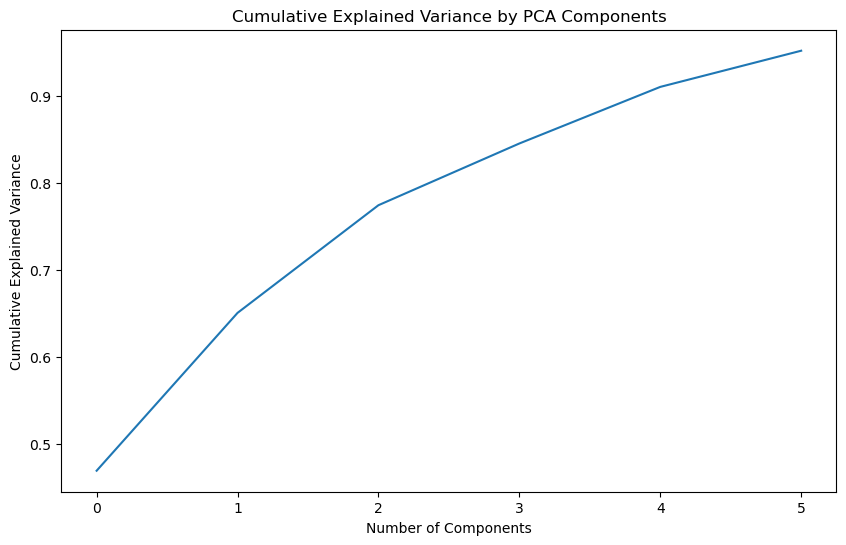

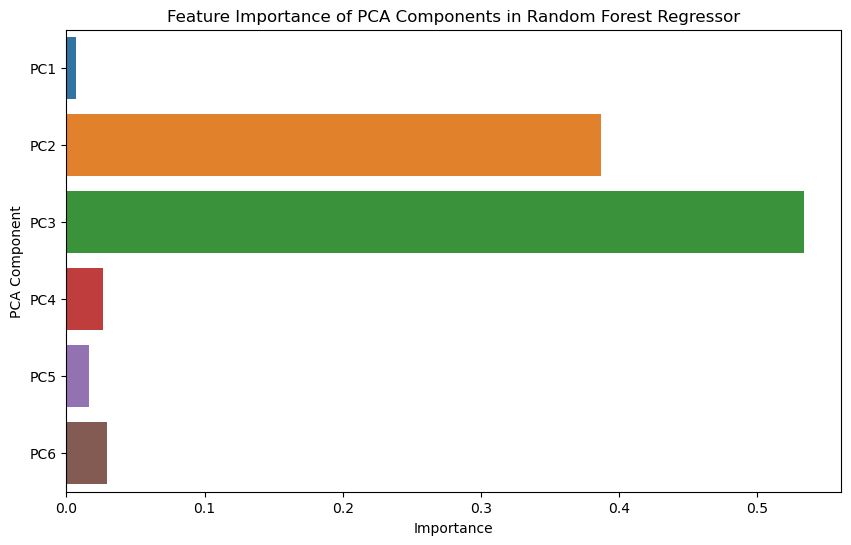

In [47]:
import yfinance as yf
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, classification_report
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Fetch historical S&P 500 data in daily timeframe
sp500_data = yf.download('^GSPC', start='2017-01-01', end='2023-01-01')

# Calculate RSI
delta = sp500_data['Close'].diff(1)
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss
sp500_data['RSI'] = 100 - (100 / (1 + rs))

# Calculate Moving Averages for Golden Cross
sp500_data['MA50'] = sp500_data['Close'].rolling(window=50).mean()
sp500_data['MA200'] = sp500_data['Close'].rolling(window=200).mean()

# Create Golden Cross indicator (1 if MA50 > MA200, else 0)
sp500_data['GoldenCross'] = np.where(sp500_data['MA50'] > sp500_data['MA200'], 1, 0)

# Calculate additional features
sp500_data['PriceChange'] = sp500_data['Close'].diff(1)
sp500_data['LogReturns'] = np.log(sp500_data['Close'] / sp500_data['Close'].shift(1))
sp500_data['PriceRatio'] = sp500_data['Close'] / sp500_data['Close'].shift(7)  # 7-day ratio
sp500_data['EMA12'] = sp500_data['Close'].ewm(span=12, adjust=False).mean()
sp500_data['EMA26'] = sp500_data['Close'].ewm(span=26, adjust=False).mean()
sp500_data['MACD'] = sp500_data['EMA12'] - sp500_data['EMA26']
sp500_data['20SMA'] = sp500_data['Close'].rolling(window=20).mean()
sp500_data['StdDev'] = sp500_data['Close'].rolling(window=20).std()
sp500_data['UpperBand'] = sp500_data['20SMA'] + (sp500_data['StdDev'] * 2)
sp500_data['LowerBand'] = sp500_data['20SMA'] - (sp500_data['StdDev'] * 2)
sp500_data['ATR'] = sp500_data['High'].rolling(window=14).max() - sp500_data['Low'].rolling(window=14).min()
sp500_data['VolumeChange'] = sp500_data['Volume'].diff(1)
sp500_data['VWAP'] = (sp500_data['Volume'] * sp500_data['Close']).cumsum() / sp500_data['Volume'].cumsum()

# Calculate the lagged closing price (previous day's closing price)
sp500_data['Lagged_Close'] = sp500_data['Close'].shift(1)

# Calculate daily returns (percentage change in closing prices)
sp500_data['Return'] = sp500_data['Close'].pct_change()

# Prepare the data with all specified features and returns as the target variable
features = ['Open', 'High', 'Low', 'RSI', 'GoldenCross', 'Lagged_Close', 'PriceChange', 'LogReturns', 
            'PriceRatio', 'MACD', 'UpperBand', 'LowerBand', 'ATR', 'VolumeChange', 'VWAP']

# Drop rows with NaN values in both features and target
data = sp500_data[features + ['Return']].dropna()

# Split the features and target
X_daily = data[features]
y_daily = data['Return']

# Standardize the data
scaler = StandardScaler()
X_daily_scaled = scaler.fit_transform(X_daily)

# Apply PCA to retain more components (e.g., capturing 95% of the variance)
pca = PCA(n_components=0.95)  # This retains components that explain 95% of the variance
X_daily_pca = pca.fit_transform(X_daily_scaled)

# Display the explained variance ratio of each component
print("Explained Variance Ratio by each Principal Component:")
print(pca.explained_variance_ratio_)

# Inspect PCA components (Optional)
# Create a DataFrame to see the contribution of each feature to the principal components
pca_components_df = pd.DataFrame(pca.components_, columns=features, index=[f'PC{i+1}' for i in range(pca.n_components_)])
print("\nPCA Component Loadings:")
print(pca_components_df)

# Plot heatmap of the PCA components
plt.figure(figsize=(12, 6))
sns.heatmap(pca_components_df, cmap='viridis', annot=True)
plt.title('PCA Component Loadings')
plt.show()

# Split the data into training and testing sets
X_train_daily, X_test_daily, y_train_daily, y_test_daily = train_test_split(X_daily_pca, y_daily, test_size=0.2, random_state=42)

# Initialize and train the Random Forest Regressor
rf_model_reg = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model_reg.fit(X_train_daily, y_train_daily)

# Predict returns on the test set
y_pred_rf_reg = rf_model_reg.predict(X_test_daily)

# Evaluate the regressor model
mse_rf = mean_squared_error(y_test_daily, y_pred_rf_reg)
r2_rf = r2_score(y_test_daily, y_pred_rf_reg)

print(f"Random Forest Regressor Mean Squared Error: {mse_rf}")
print(f"Random Forest Regressor R^2 Score: {r2_rf}")

# Convert the returns to binary classes for classification (1 if return > 0, else 0)
y_daily_class = (y_daily > 0).astype(int)

# Split the data into training and testing sets for classification
X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(X_daily_pca, y_daily_class, test_size=0.2, random_state=42)

# Initialize and train the Random Forest Classifier
rf_model_class = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model_class.fit(X_train_class, y_train_class)

# Predict classes on the test set
y_pred_rf_class = rf_model_class.predict(X_test_class)

# Evaluate the classifier model
accuracy_rf = accuracy_score(y_test_class, y_pred_rf_class)
print(f"Random Forest Classifier Accuracy: {accuracy_rf}")

# Print classification report
print("Classification Report:")
print(classification_report(y_test_class, y_pred_rf_class))

# Plotting the actual vs predicted returns for the regressor
plt.figure(figsize=(10, 6))
y_test_daily_sorted = y_test_daily.sort_index()
y_pred_rf_reg_sorted = pd.Series(y_pred_rf_reg, index=y_test_daily.index).sort_index()
plt.plot(y_test_daily_sorted.index, y_test_daily_sorted, label='Actual Returns', color='blue', marker='o')
plt.plot(y_pred_rf_reg_sorted.index, y_pred_rf_reg_sorted, label='Predicted Returns', color='red', linestyle='--', marker='x')

# Add a line of best fit for predicted returns
z_rf = np.polyfit(y_test_daily_sorted, y_pred_rf_reg_sorted, 1)
p_rf = np.poly1d(z_rf)
plt.plot(y_test_daily_sorted.index, p_rf(y_test_daily_sorted), label='Best Fit Line', color='green', linestyle='-')

plt.title('S&P 500 Daily Actual vs Predicted Returns (Random Forest Regressor with PCA)')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.legend()
plt.show()

# Display the explained variance by each PCA component
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance by PCA Components')
plt.show()

# Since feature_importances_ corresponds to the PCA components and not the original features, 
# we need to create a feature importance plot that reflects the PCA-transformed features.
# Instead of original features, we now have principal components.

# Feature importance for PCA components
pca_feature_importances = pd.DataFrame({
    'PCA Component': [f'PC{i+1}' for i in range(pca.n_components_)],
    'Importance': rf_model_reg.feature_importances_
})

# Visualize feature importance of PCA components
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='PCA Component', data=pca_feature_importances)
plt.title('Feature Importance of PCA Components in Random Forest Regressor')
plt.show()


In [52]:
# Predict returns on the test set
y_pred_rf_reg = best_rf.predict(X_test_daily)

# Evaluate the regressor model
mse_rf = mean_squared_error(y_test_daily, y_pred_rf_reg)
r2_rf = r2_score(y_test_daily, y_pred_rf_reg)

print(f"Random Forest Regressor Mean Squared Error: {mse_rf}")
print(f"Random Forest Regressor R^2 Score: {r2_rf}")

Random Forest Regressor Mean Squared Error: 0.0003121100949207074
Random Forest Regressor R^2 Score: 0.8091218739641419


# Recursive Feature Elimination (RFE) and Lasso Regression (L1 Regularization)

[*********************100%%**********************]  1 of 1 completed


Selected Features by RFE: Index(['PriceChange', 'LogReturns', 'PriceRatio', 'MACD', 'ATR'], dtype='object')
R^2 Score using RFE: 0.9982527326865382
Selected Features by Lasso: Index(['LogReturns'], dtype='object')
R^2 Score using Lasso: 0.9988194833936965


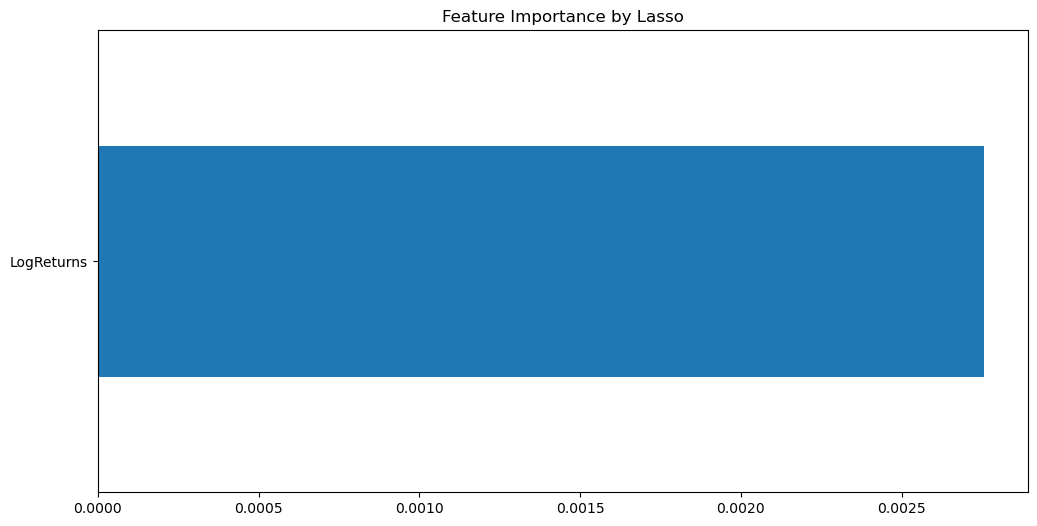

In [49]:
import yfinance as yf
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, classification_report
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Fetch historical S&P 500 data in daily timeframe
sp500_data = yf.download('^GSPC', start='2017-01-01', end='2023-01-01')

# Calculate RSI
delta = sp500_data['Close'].diff(1)
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss
sp500_data['RSI'] = 100 - (100 / (1 + rs))

# Calculate Moving Averages for Golden Cross
sp500_data['MA50'] = sp500_data['Close'].rolling(window=50).mean()
sp500_data['MA200'] = sp500_data['Close'].rolling(window=200).mean()

# Create Golden Cross indicator (1 if MA50 > MA200, else 0)
sp500_data['GoldenCross'] = np.where(sp500_data['MA50'] > sp500_data['MA200'], 1, 0)

# Calculate additional features
sp500_data['PriceChange'] = sp500_data['Close'].diff(1)
sp500_data['LogReturns'] = np.log(sp500_data['Close'] / sp500_data['Close'].shift(1))
sp500_data['PriceRatio'] = sp500_data['Close'] / sp500_data['Close'].shift(7)  # 7-day ratio
sp500_data['EMA12'] = sp500_data['Close'].ewm(span=12, adjust=False).mean()
sp500_data['EMA26'] = sp500_data['Close'].ewm(span=26, adjust=False).mean()
sp500_data['MACD'] = sp500_data['EMA12'] - sp500_data['EMA26']
sp500_data['20SMA'] = sp500_data['Close'].rolling(window=20).mean()
sp500_data['StdDev'] = sp500_data['Close'].rolling(window=20).std()
sp500_data['UpperBand'] = sp500_data['20SMA'] + (sp500_data['StdDev'] * 2)
sp500_data['LowerBand'] = sp500_data['20SMA'] - (sp500_data['StdDev'] * 2)
sp500_data['ATR'] = sp500_data['High'].rolling(window=14).max() - sp500_data['Low'].rolling(window=14).min()
sp500_data['VolumeChange'] = sp500_data['Volume'].diff(1)
sp500_data['VWAP'] = (sp500_data['Volume'] * sp500_data['Close']).cumsum() / sp500_data['Volume'].cumsum()

# Calculate the lagged closing price (previous day's closing price)
sp500_data['Lagged_Close'] = sp500_data['Close'].shift(1)

# Calculate daily returns (percentage change in closing prices)
sp500_data['Return'] = sp500_data['Close'].pct_change()

# Prepare the data with all specified features and returns as the target variable
features = ['Open', 'High', 'Low', 'RSI', 'GoldenCross', 'Lagged_Close', 'PriceChange', 'LogReturns',
            'PriceRatio', 'MACD', 'UpperBand', 'LowerBand', 'ATR', 'VolumeChange', 'VWAP']

# Drop rows with NaN values in both features and target
data = sp500_data[features + ['Return']].dropna()

# Split the features and target
X_daily = data[features]
y_daily = data['Return']

# Standardize the data
scaler = StandardScaler()
X_daily_scaled = scaler.fit_transform(X_daily)

### Recursive Feature Elimination (RFE) with Random Forest Regressor ###
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rfe = RFE(estimator=rf_model, n_features_to_select=5)  # Choose 5 most important features
rfe.fit(X_daily_scaled, y_daily)

# Get selected features
selected_features_rfe = X_daily.columns[rfe.support_]
print("Selected Features by RFE:", selected_features_rfe)

# Train the model using the selected features from RFE
X_selected_rfe = X_daily[selected_features_rfe]
X_selected_rfe_scaled = scaler.fit_transform(X_selected_rfe)
rf_model.fit(X_selected_rfe_scaled, y_daily)

# Evaluate RFE model
y_pred_rf_rfe = rf_model.predict(X_selected_rfe_scaled)
r2_rf_rfe = r2_score(y_daily, y_pred_rf_rfe)
print(f"R^2 Score using RFE: {r2_rf_rfe}")

### Lasso Regression (L1 Regularization) for Feature Selection ###
lasso = Lasso(alpha=0.01)  # Regularization strength
lasso.fit(X_daily_scaled, y_daily)

# Get coefficients of features
lasso_coefficients = pd.Series(lasso.coef_, index=X_daily.columns)
selected_features_lasso = lasso_coefficients[lasso_coefficients != 0].index
print("Selected Features by Lasso:", selected_features_lasso)

# Train the model using the selected features from Lasso
X_selected_lasso = X_daily[selected_features_lasso]
X_selected_lasso_scaled = scaler.fit_transform(X_selected_lasso)
rf_model.fit(X_selected_lasso_scaled, y_daily)

# Evaluate Lasso model
y_pred_rf_lasso = rf_model.predict(X_selected_lasso_scaled)
r2_rf_lasso = r2_score(y_daily, y_pred_rf_lasso)
print(f"R^2 Score using Lasso: {r2_rf_lasso}")

### Visualizing the Importance of Features Selected by Lasso ###
plt.figure(figsize=(12, 6))
lasso_coefficients[lasso_coefficients != 0].sort_values().plot(kind='barh')
plt.title('Feature Importance by Lasso')
plt.show()


# MODELS AFTER FEATURE FEATURE REDUCTION
removed logreturns

In [50]:
import yfinance as yf
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Fetch historical S&P 500 data in daily timeframe
sp500_data = yf.download('^GSPC', start='2017-01-01', end='2023-01-01')

# Calculate RSI
delta = sp500_data['Close'].diff(1)
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss
sp500_data['RSI'] = 100 - (100 / (1 + rs))

# Calculate Moving Averages for Golden Cross
sp500_data['MA50'] = sp500_data['Close'].rolling(window=50).mean()
sp500_data['MA200'] = sp500_data['Close'].rolling(window=200).mean()

# Create Golden Cross indicator (1 if MA50 > MA200, else 0)
sp500_data['GoldenCross'] = np.where(sp500_data['MA50'] > sp500_data['MA200'], 1, 0)

# Calculate additional features
sp500_data['PriceChange'] = sp500_data['Close'].diff(1)
sp500_data['LogReturns'] = np.log(sp500_data['Close'] / sp500_data['Close'].shift(1))
sp500_data['PriceRatio'] = sp500_data['Close'] / sp500_data['Close'].shift(7)  # 7-day ratio
sp500_data['EMA12'] = sp500_data['Close'].ewm(span=12, adjust=False).mean()
sp500_data['EMA26'] = sp500_data['Close'].ewm(span=26, adjust=False).mean()
sp500_data['MACD'] = sp500_data['EMA12'] - sp500_data['EMA26']
sp500_data['20SMA'] = sp500_data['Close'].rolling(window=20).mean()
sp500_data['StdDev'] = sp500_data['Close'].rolling(window=20).std()
sp500_data['UpperBand'] = sp500_data['20SMA'] + (sp500_data['StdDev'] * 2)
sp500_data['LowerBand'] = sp500_data['20SMA'] - (sp500_data['StdDev'] * 2)
sp500_data['ATR'] = sp500_data['High'].rolling(window=14).max() - sp500_data['Low'].rolling(window=14).min()
sp500_data['VolumeChange'] = sp500_data['Volume'].diff(1)
sp500_data['VWAP'] = (sp500_data['Volume'] * sp500_data['Close']).cumsum() / sp500_data['Volume'].cumsum()

# Calculate the lagged closing price (previous day's closing price)
sp500_data['Lagged_Close'] = sp500_data['Close'].shift(1)

# Calculate daily returns (percentage change in closing prices)
sp500_data['Return'] = sp500_data['Close'].pct_change()

# Prepare the data with all specified features and returns as the target variable
features = ['Open', 'High', 'Low', 'RSI', 'Lagged_Close', 'PriceChange',
            'PriceRatio', 'MACD', 'UpperBand', 'LowerBand', 'ATR', 'VWAP']

# Drop rows with NaN values in both features and target
data = sp500_data[features + ['Return']].dropna()

# Split the features and target
X_daily = data[features]
y_daily = data['Return']

# Standardize the data
scaler = StandardScaler()
X_daily_scaled = scaler.fit_transform(X_daily)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_daily_scaled, y_daily, test_size=0.2, random_state=42)

# Train and evaluate a Linear Regression model (without PCA)
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)

# Calculate and print evaluation metrics for Linear Regression
mse_lr = mean_squared_error(y_test, y_pred_lr)
mae_lr = mean_absolute_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)
print(f"Linear Regression Mean Squared Error: {mse_lr}")
print(f"Linear Regression Mean Absolute Error: {mae_lr}")
print(f"Linear Regression R^2 Score: {r2_lr}")

# Calculate the number of trading days in a year
trading_days = 252

# Calculate the mean of daily returns predicted by the Linear Regression model
mean_daily_return_lr = y_pred_lr.mean()

# Annualize the return
annualized_return_lr = mean_daily_return_lr * trading_days
print(f"Annualized Expected Return using Linear Regression: {annualized_return_lr}")

# Apply PCA only to the Random Forest model
pca = PCA(n_components=0.95)  # Retain components that explain 95% of variance
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Train and evaluate the Random Forest Regressor model with PCA-transformed features
best_rf = RandomForestRegressor(n_estimators=100, random_state=42)
best_rf.fit(X_train_pca, y_train)
y_pred_rf_reg = best_rf.predict(X_test_pca)

# Calculate and print evaluation metrics for Random Forest Regressor
mse_rf = mean_squared_error(y_test, y_pred_rf_reg)
mae_rf = mean_absolute_error(y_test, y_pred_rf_reg)
r2_rf = r2_score(y_test, y_pred_rf_reg)

print(f"Random Forest Regressor Mean Squared Error: {mse_rf}")
print(f"Random Forest Regressor Mean Absolute Error: {mae_rf}")
print(f"Random Forest Regressor R^2 Score: {r2_rf}")

# Calculate the mean of daily returns predicted by the Random Forest model
mean_daily_return_rf = y_pred_rf_reg.mean()

# Annualize the return
annualized_return_rf = mean_daily_return_rf * trading_days
print(f"Annualized Expected Return using Random Forest Regressor: {annualized_return_rf}")


[*********************100%%**********************]  1 of 1 completed

Linear Regression Mean Squared Error: 5.4405481588468104e-06
Linear Regression Mean Absolute Error: 0.001436275839174581
Linear Regression R^2 Score: 0.9615267156831814
Annualized Expected Return using Linear Regression: 0.1095212091631252


Random Forest Regressor Mean Squared Error: 1.2615542275163913e-05
Random Forest Regressor Mean Absolute Error: 0.0017106266805185033
Random Forest Regressor R^2 Score: 0.9107881539521003
Annualized Expected Return using Random Forest Regressor: 0.13461372026360155


## CROSS VALIDATION

In [17]:
import yfinance as yf
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Use TimeSeriesSplit for cross-validation since it is more appropriate for time-series data
tscv = TimeSeriesSplit(n_splits=5)

# Perform cross-validation for Linear Regression
lr_model = LinearRegression()
lr_cv_scores = cross_val_score(lr_model, X_daily_pca, y_daily, cv=tscv, scoring='r2')

# Perform cross-validation for Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_cv_scores = cross_val_score(rf_model, X_daily_pca, y_daily, cv=tscv, scoring='r2')

# Print the cross-validation scores for Linear Regression
print(f"Linear Regression Cross-validated R^2 scores: {lr_cv_scores}")
print(f"Mean R^2 (Linear Regression): {lr_cv_scores.mean()}")
print(f"Standard Deviation of R^2 (Linear Regression): {lr_cv_scores.std()}")

# Print the cross-validation scores for Random Forest Regressor
print(f"Random Forest Regressor Cross-validated R^2 scores: {rf_cv_scores}")
print(f"Mean R^2 (Random Forest Regressor): {rf_cv_scores.mean()}")
print(f"Standard Deviation of R^2 (Random Forest Regressor): {rf_cv_scores.std()}")


Linear Regression Cross-validated R^2 scores: [0.98371165 0.9961434  0.99206605 0.92685655 0.96556283]
Mean R^2 (Linear Regression): 0.9728680967433446
Standard Deviation of R^2 (Linear Regression): 0.025291551009331125
Random Forest Regressor Cross-validated R^2 scores: [0.59998997 0.94880981 0.67914123 0.95024654 0.91420791]
Mean R^2 (Random Forest Regressor): 0.818479094486799
Standard Deviation of R^2 (Random Forest Regressor): 0.14877183794623702


# GridSearchCV
Further optimze the RF to make it more effective

In [19]:
import yfinance as yf
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import make_scorer, mean_squared_error, r2_score

# Fetch historical S&P 500 data in daily timeframe
sp500_data = yf.download('^GSPC', start='2017-01-01', end='2023-01-01')

# Calculate RSI
delta = sp500_data['Close'].diff(1)
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss
sp500_data['RSI'] = 100 - (100 / (1 + rs))

# Calculate Moving Averages for Golden Cross
sp500_data['MA50'] = sp500_data['Close'].rolling(window=50).mean()
sp500_data['MA200'] = sp500_data['Close'].rolling(window=200).mean()

# Create Golden Cross indicator (1 if MA50 > MA200, else 0)
sp500_data['GoldenCross'] = np.where(sp500_data['MA50'] > sp500_data['MA200'], 1, 0)

# Calculate additional features
sp500_data['PriceChange'] = sp500_data['Close'].diff(1)
sp500_data['LogReturns'] = np.log(sp500_data['Close'] / sp500_data['Close'].shift(1))
sp500_data['PriceRatio'] = sp500_data['Close'] / sp500_data['Close'].shift(7)  # 7-day ratio
sp500_data['EMA12'] = sp500_data['Close'].ewm(span=12, adjust=False).mean()
sp500_data['EMA26'] = sp500_data['Close'].ewm(span=26, adjust=False).mean()
sp500_data['MACD'] = sp500_data['EMA12'] - sp500_data['EMA26']
sp500_data['20SMA'] = sp500_data['Close'].rolling(window=20).mean()
sp500_data['StdDev'] = sp500_data['Close'].rolling(window=20).std()
sp500_data['UpperBand'] = sp500_data['20SMA'] + (sp500_data['StdDev'] * 2)
sp500_data['LowerBand'] = sp500_data['20SMA'] - (sp500_data['StdDev'] * 2)
sp500_data['ATR'] = sp500_data['High'].rolling(window=14).max() - sp500_data['Low'].rolling(window=14).min()
sp500_data['VolumeChange'] = sp500_data['Volume'].diff(1)
sp500_data['VWAP'] = (sp500_data['Volume'] * sp500_data['Close']).cumsum() / sp500_data['Volume'].cumsum()

# Calculate the lagged closing price (previous day's closing price)
sp500_data['Lagged_Close'] = sp500_data['Close'].shift(1)

# Calculate daily returns (percentage change in closing prices)
sp500_data['Return'] = sp500_data['Close'].pct_change()

# Prepare the data with all specified features and returns as the target variable
features = ['Open', 'High', 'Low', 'RSI', 'Lagged_Close', 'PriceChange',
            'PriceRatio', 'MACD', 'UpperBand', 'LowerBand', 'ATR', 'VWAP']

# Drop rows with NaN values in both features and target
data = sp500_data[features + ['Return']].dropna()

# Split the features and target
X_daily = data[features]
y_daily = data['Return']

# Standardize the data
scaler = StandardScaler()
X_daily_scaled = scaler.fit_transform(X_daily)

# Apply PCA to retain more components (e.g., capturing 95% of the variance)
pca = PCA(n_components=0.95)
X_daily_pca = pca.fit_transform(X_daily_scaled)

# Define the Random Forest model
rf_model = RandomForestRegressor(random_state=42)

# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Scorer for GridSearchCV
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)

# Perform GridSearchCV with 5-fold cross-validation
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, 
                           scoring=mse_scorer, cv=5, n_jobs=-1, verbose=2)

# Fit the model with GridSearchCV
grid_search.fit(X_daily_pca, y_daily)

# Print the best parameters and best score
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Score (Negative MSE): {-grid_search.best_score_}")

# Get the best model from GridSearchCV
best_rf = grid_search.best_estimator_

# Evaluate the best model on the test set
X_train, X_test, y_train, y_test = train_test_split(X_daily_pca, y_daily, test_size=0.2, random_state=42)
y_pred_rf = best_rf.predict(X_test)

# Calculate and print evaluation metrics for the best Random Forest model
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Best Random Forest Regressor Mean Squared Error: {mse_rf}")
print(f"Best Random Forest Regressor R^2 Score: {r2_rf}")


[*********************100%%**********************]  1 of 1 completed


Fitting 5 folds for each of 162 candidates, totalling 810 fits
Best Parameters: {'bootstrap': True, 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best Score (Negative MSE): 2.8902736609899354e-05
Best Random Forest Regressor Mean Squared Error: 1.7532411224402952e-06
Best Random Forest Regressor R^2 Score: 0.9876018110289311


# ENSEMBLE THE MODELS
combining LR and RF models together to increase predictability

In [39]:
import yfinance as yf
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import numpy as np

# Fetch historical S&P 500 data in daily timeframe
sp500_data = yf.download('^GSPC', start='2017-01-01', end='2023-01-01')

# Calculate RSI
delta = sp500_data['Close'].diff(1)
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss
sp500_data['RSI'] = 100 - (100 / (1 + rs))

# Calculate Moving Averages for Golden Cross
sp500_data['MA50'] = sp500_data['Close'].rolling(window=50).mean()
sp500_data['MA200'] = sp500_data['Close'].rolling(window=200).mean()

# Create Golden Cross indicator (1 if MA50 > MA200, else 0)
sp500_data['GoldenCross'] = np.where(sp500_data['MA50'] > sp500_data['MA200'], 1, 0)

# Calculate additional features
sp500_data['PriceChange'] = sp500_data['Close'].diff(1)
sp500_data['LogReturns'] = np.log(sp500_data['Close'] / sp500_data['Close'].shift(1))
sp500_data['PriceRatio'] = sp500_data['Close'] / sp500_data['Close'].shift(7)  # 7-day ratio
sp500_data['EMA12'] = sp500_data['Close'].ewm(span=12, adjust=False).mean()
sp500_data['EMA26'] = sp500_data['Close'].ewm(span=26, adjust=False).mean()
sp500_data['MACD'] = sp500_data['EMA12'] - sp500_data['EMA26']
sp500_data['20SMA'] = sp500_data['Close'].rolling(window=20).mean()
sp500_data['StdDev'] = sp500_data['Close'].rolling(window=20).std()
sp500_data['UpperBand'] = sp500_data['20SMA'] + (sp500_data['StdDev'] * 2)
sp500_data['LowerBand'] = sp500_data['20SMA'] - (sp500_data['StdDev'] * 2)
sp500_data['ATR'] = sp500_data['High'].rolling(window=14).max() - sp500_data['Low'].rolling(window=14).min()
sp500_data['VolumeChange'] = sp500_data['Volume'].diff(1)
sp500_data['VWAP'] = (sp500_data['Volume'] * sp500_data['Close']).cumsum() / sp500_data['Volume'].cumsum()

# Calculate the lagged closing price (previous day's closing price)
sp500_data['Lagged_Close'] = sp500_data['Close'].shift(1)

# Calculate daily returns (percentage change in closing prices)
sp500_data['Return'] = sp500_data['Close'].pct_change()

# Prepare the data with all specified features and returns as the target variable
features = ['Open', 'High', 'Low', 'RSI', 'GoldenCross', 'Lagged_Close', 'PriceChange',
            'PriceRatio', 'MACD', 'UpperBand', 'LowerBand', 'ATR', 'VWAP']

# Drop rows with NaN values in both features and target
data = sp500_data[features + ['Return']].dropna()

# Split the features and target
X_daily = data[features]
y_daily = data['Return']

# Standardize the data
scaler = StandardScaler()
X_daily_scaled = scaler.fit_transform(X_daily)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_daily_scaled, y_daily, test_size=0.2, random_state=42)

# Train and evaluate a Linear Regression model (without PCA)
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)

# Calculate and print evaluation metrics for Linear Regression
mse_lr = mean_squared_error(y_test, y_pred_lr)
mae_lr = mean_absolute_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)
print(f"Linear Regression Mean Squared Error: {mse_lr}")
print(f"Linear Regression Mean Absolute Error: {mae_lr}")
print(f"Linear Regression R^2 Score: {r2_lr}")

# Calculate the number of trading days in a year
trading_days = 252

# Calculate the mean of daily returns predicted by the Linear Regression model
mean_daily_return_lr = y_pred_lr.mean()

# Annualize the return
annualized_return_lr = mean_daily_return_lr * trading_days
print(f"Annualized Expected Return using Linear Regression: {annualized_return_lr}")

# Apply PCA only to the Random Forest model
pca = PCA(n_components=0.95)  # Retain components that explain 95% of variance
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Train and evaluate the Random Forest Regressor model with PCA-transformed features
best_rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=20,
    min_samples_split=2,
    min_samples_leaf=1,
    bootstrap=True,
    random_state=42
)
best_rf.fit(X_train_pca, y_train)
y_pred_rf_reg = best_rf.predict(X_test_pca)

# Calculate and print evaluation metrics for Random Forest Regressor
mse_rf = mean_squared_error(y_test, y_pred_rf_reg)
mae_rf = mean_absolute_error(y_test, y_pred_rf_reg)
r2_rf = r2_score(y_test, y_pred_rf_reg)

print(f"Random Forest Regressor Mean Squared Error: {mse_rf}")
print(f"Random Forest Regressor Mean Absolute Error: {mae_rf}")
print(f"Random Forest Regressor R^2 Score: {r2_rf}")

# Calculate the mean of daily returns predicted by the Random Forest model
mean_daily_return_rf = y_pred_rf_reg.mean()

# Annualize the return
annualized_return_rf = mean_daily_return_rf * trading_days
print(f"Annualized Expected Return using Random Forest Regressor: {annualized_return_rf}")

# Ensemble: Weighted Average of Linear Regression and Random Forest Regressor
# Assign more weight to the Random Forest model as it performs better
weight_rf = 0.4834
weight_lr = 0.5166

# Combined predictions
y_pred_ensemble = (weight_rf * y_pred_rf_reg) + (weight_lr * y_pred_lr)

# Calculate and print evaluation metrics for the ensemble model
mse_ensemble = mean_squared_error(y_test, y_pred_ensemble)
mae_ensemble = mean_absolute_error(y_test, y_pred_ensemble)
r2_ensemble = r2_score(y_test, y_pred_ensemble)

print(f"Ensemble Model Mean Squared Error: {mse_ensemble}")
print(f"Ensemble Model Mean Absolute Error: {mae_ensemble}")
print(f"Ensemble Model R^2 Score: {r2_ensemble}")

# Calculate the mean of daily returns predicted by the Ensemble model
mean_daily_return_ensemble = y_pred_ensemble.mean()

# Annualize the return
annualized_return_ensemble = mean_daily_return_ensemble * trading_days
print(f"Annualized Expected Return using Ensemble Model: {annualized_return_ensemble}")


[*********************100%%**********************]  1 of 1 completed


Linear Regression Mean Squared Error: 5.434649206009617e-06
Linear Regression Mean Absolute Error: 0.0014396226522254776
Linear Regression R^2 Score: 0.9615684306139293
Annualized Expected Return using Linear Regression: 0.10809420621914621
Random Forest Regressor Mean Squared Error: 1.4243841158517952e-05
Random Forest Regressor Mean Absolute Error: 0.0017906249934517865
Random Forest Regressor R^2 Score: 0.8992735043133189
Annualized Expected Return using Random Forest Regressor: 0.10156366805999074
Ensemble Model Mean Squared Error: 6.082309387431208e-06
Ensemble Model Mean Absolute Error: 0.001351253067363497
Ensemble Model R^2 Score: 0.9569884483082867
Annualized Expected Return using Ensemble Model: 0.10493734407301046


# PREDICTED ANNUAL RETURNS

In [35]:
# Calculate the number of trading days in a year
trading_days = 252

# Calculate the mean of daily returns predicted by each model
mean_daily_return_lr = y_pred_lr.mean()
mean_daily_return_rf = y_pred_rf.mean()

# Annualize the returns
annualized_return_lr = mean_daily_return_lr * trading_days
annualized_return_rf = mean_daily_return_rf * trading_days

print(f"Annualized Expected Return using Linear Regression: {annualized_return_lr}")
print(f"Annualized Expected Return using Random Forest Regressor: {annualized_return_rf}")


Annualized Expected Return using Linear Regression: 0.10809420621914621
Annualized Expected Return using Random Forest Regressor: 0.12809437432203208


## COMBINED EXPECTED RETURNS
FOR LR AND RF

In [ ]:
combined_expected_return = (weight_lr * expected_return_lr) + (weight_rf * expected_return_rf)


In [41]:
# Assume these are the previously calculated annualized expected returns
annualized_return_lr = 0.10809420621914621 # Example value from your earlier output
annualized_return_rf = 0.10156366805999074  # Example value from your earlier output

# Combine the expected returns using the same weights
weight_rf = 0.4834
weight_lr = 0.5166  # Same weight as used for combining predictions

combined_expected_return = (weight_lr * annualized_return_lr) + (weight_rf * annualized_return_rf)

print(f"Combined Annualized Expected Return: {combined_expected_return}")


Combined Annualized Expected Return: 0.10493734407301045


In [27]:
import yfinance as yf

# Fetch historical S&P 500 data in daily timeframe
sp500_data = yf.download('^GSPC', start='2017-01-01', end='2023-12-31')

# Get the initial and final closing prices
initial_price = sp500_data['Close'].iloc[0]
final_price = sp500_data['Close'].iloc[-1]

# Calculate the number of years
n_years = (sp500_data.index[-1] - sp500_data.index[0]).days / 365.25

# Calculate the cumulative return
cumulative_return = final_price / initial_price - 1

# Calculate the actual annualized return
actual_annualized_return = (1 + cumulative_return) ** (1 / n_years) - 1

# Convert to percentage
actual_annualized_return_percentage = actual_annualized_return * 100

print(f"Actual Annualized Return (2017-2023): {actual_annualized_return_percentage:.2f}%")


[*********************100%%**********************]  1 of 1 completed

Actual Annualized Return (2017-2023): 11.30%
